In [1]:
%pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install pandas
%pip install numpy


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install tensorflow
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout, Dense, LSTM
import matplotlib.pyplot as plt


2024-11-20 19:42:06.097856: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 19:42:06.125291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732142526.161568  126749 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732142526.172200  126749 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 19:42:06.207431: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Carregamento e tratamento dos dados

In [132]:
# Carregar e tratar dados
file_path = 'dados_covid_sp_diario.csv'
data = pd.read_csv(file_path, delimiter=';')
data = data[data['nome_munic']!='Ignorado']
df =  data
df['datahora'] = pd.to_datetime(df['datahora'])
df['casos_novos'] = pd.to_numeric(df['casos_novos'])
df['casos'] = pd.to_numeric(df['casos'])
df['obitos'] = pd.to_numeric(df['obitos'])
df['obitos_novos'] = pd.to_numeric(df['obitos_novos'])
df['casos_mm7d'] =df['casos_mm7d'].apply(lambda x: x.replace(',','.'))
df['obitos_mm7d'] =df['casos_mm7d'].apply(lambda x: x.replace(',','.'))
df['casos_mm7d'] = pd.to_numeric(df['casos_mm7d'])
df['obitos_mm7d']  = pd.to_numeric(df['obitos_mm7d'])
df['semana_epidem'] = pd.to_numeric(df['semana_epidem'])

In [8]:
df

,nome_munic,codigo_ibge,datahora,casos,casos_novos,casos_mm7d,obitos,obitos_novos,obitos_mm7d,pop,semana_epidem
0,Adamantina,3500105,2020-02-25,0,0,0.000000,0,0,0.000000,33894,9
1,Adolfo,3500204,2020-02-25,0,0,0.000000,0,0,0.000000,3447,9
2,Aguaí,3500303,2020-02-25,0,0,0.000000,0,0,0.000000,35608,9
3,Águas da Prata,3500402,2020-02-25,0,0,0.000000,0,0,0.000000,7797,9
4,Águas de Lindóia,3500501,2020-02-25,0,0,0.000000,0,0,0.000000,18374,9
...,...,...,...,...,...,...,...,...,...,...,...
879130,Votorantim,3557006,2023-11-18,12613,0,0.285714,581,0,0.285714,119824,46
879131,Votuporanga,3557105,2023-11-18,33699,0,3.428571,514,0,3.428571,91760,46
879132,Zacarias,3557154,2023-11-18,386,1,0.142857,12,0,0.142857,2560,46
879133,Chavantes,3557204,2023-11-18,2814,0,0.000000,62,0,0.000000,12223,46


In [9]:
df_copy = df

# Matrix de correlação

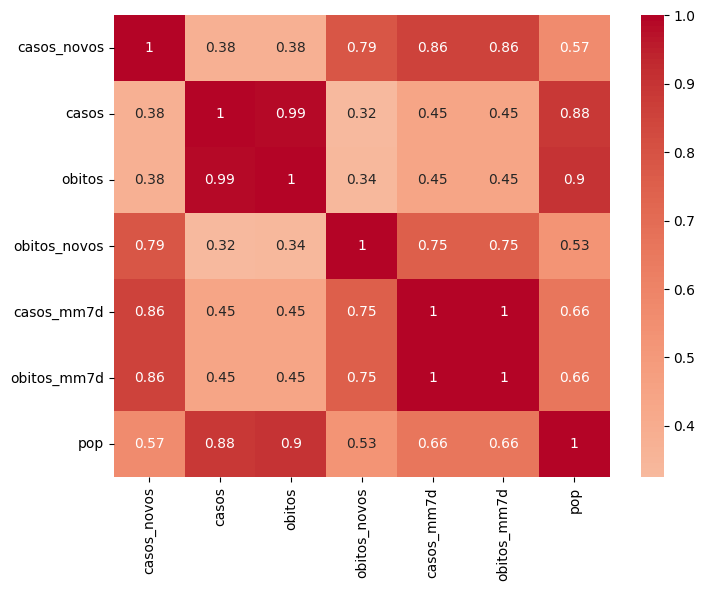

In [133]:
correlation_matrix = df[['casos_novos','casos','obitos','obitos_novos','casos_mm7d','obitos_mm7d','pop']].corr()
import seaborn as sns
import matplotlib.pyplot as plt

# Criando o mapa de calor
plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

# Exibindo o mapa de calor
plt.show()

# Agrupamento dos dados do dataframe

In [134]:
df_train = df[['casos_novos','casos','obitos','obitos_novos','casos_mm7d','obitos_mm7d','datahora']]
df_train = df.groupby('datahora').agg({
    'casos_novos': 'sum',
    #'casos': 'sum',
    #'obitos': 'sum',
    'obitos_novos': 'sum',
    'casos_mm7d': 'mean',
    'obitos_mm7d': 'mean'
})
df_train['casos_novos_corrigidos'] = df_train['casos_novos'].rolling(window=7, center=True).mean() 



In [135]:
df_train = df_train.dropna(subset=['casos_novos_corrigidos'])

In [136]:
df_train

,casos_novos,obitos_novos,casos_mm7d,obitos_mm7d,casos_novos_corrigidos
datahora,,,,,
2020-02-28,1,0,0.000000,0.000000,0.142857
2020-02-29,0,0,0.000000,0.000000,0.142857
2020-03-01,0,0,0.000000,0.000000,0.285714
2020-03-02,0,0,0.000221,0.000221,0.714286
2020-03-03,0,0,0.000221,0.000221,0.571429
...,...,...,...,...,...
2023-11-11,1617,29,2.371429,2.371429,1408.428571
2023-11-12,135,0,2.304762,2.304762,1650.000000
2023-11-13,182,1,2.328682,2.328682,1057.285714


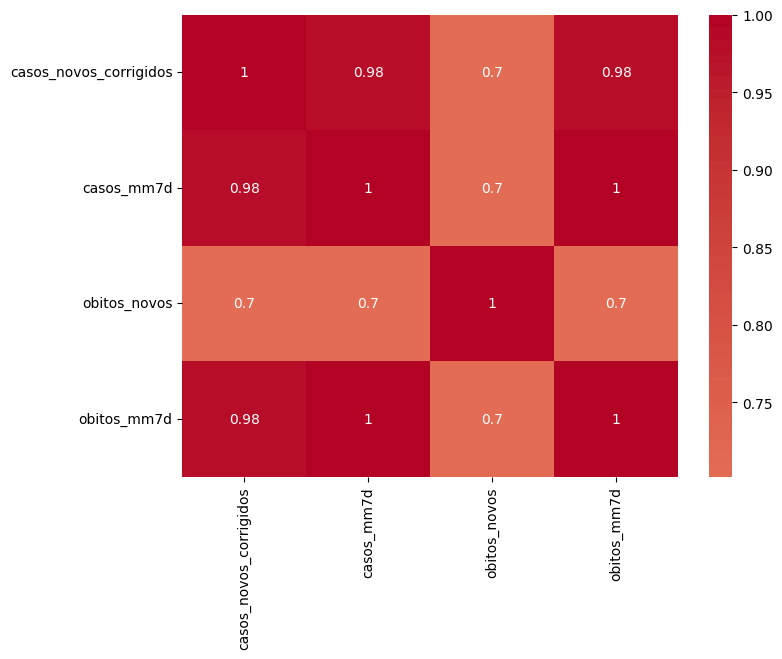

In [137]:
correlation_matrix = df_train[['casos_novos_corrigidos','casos_mm7d','obitos_novos','obitos_mm7d']].corr()
import seaborn as sns
import matplotlib.pyplot as plt

# Criando o mapa de calor
plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

# Exibindo o mapa de calor
plt.show()

In [15]:
%pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [63]:
df_train

,casos_novos,obitos_novos,casos_mm7d,obitos_mm7d,casos_novos_corrigidos
datahora,,,,,
2020-02-28,1,0,0.000000,0.000000,0.142857
2020-02-29,0,0,0.000000,0.000000,0.142857
2020-03-01,0,0,0.000000,0.000000,0.285714
2020-03-02,0,0,0.000221,0.000221,0.714286
2020-03-03,0,0,0.000221,0.000221,0.571429
...,...,...,...,...,...
2023-11-11,1617,29,2.371429,2.371429,1408.428571
2023-11-12,135,0,2.304762,2.304762,1650.000000
2023-11-13,182,1,2.328682,2.328682,1057.285714


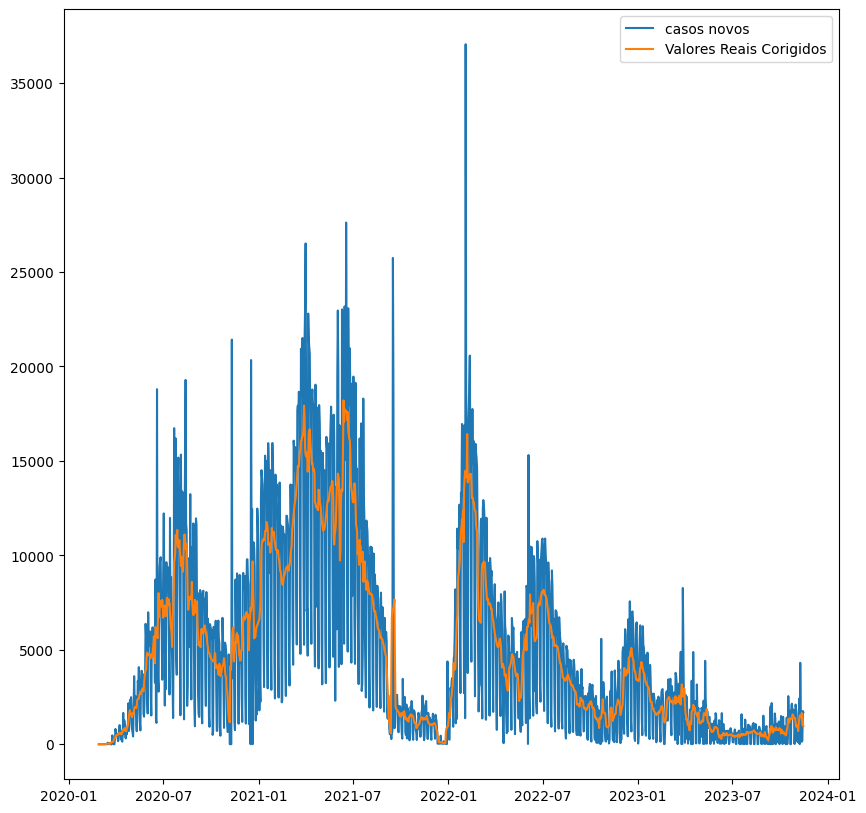

In [138]:
plt.figure(figsize=(10, 10))
#plt.plot(df_train['casos_novos'], label='Valores Reais')
plt.plot(df_train['casos_novos'],label='casos novos')
plt.plot(df_train['casos_novos_corrigidos'], label='Valores Reais Corigidos')

plt.legend()
plt.show()

In [139]:
df_train_copy = df_train
#df_train = df_train[['obitos_novos','casos_mm7d','obitos_mm7d']]
df_train = df_train[['obitos_novos','obitos_mm7d','casos_mm7d']]

In [76]:
df_train

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.84849270e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.80788460e-02, 7.20461095e-04, 8.25184046e-02, 8.25184046e-02],
       [5.49786913e-02, 2.30547550e-02, 7.73776822e-02, 7.73776822e-02],
       [5.27340224e-02, 2.16138329e-02, 9.06493792e-02, 9.06493792e-02]])

# Realizando o Scaller dos dados 

In [140]:
scaler = MinMaxScaler()
sc_feature =  MinMaxScaler()
#df_train['obitos_novos'] = scaler.fit_transform(df_train[['obitos_novos']])
#df_train['casos_mm7d'] = scaler.fit_transform(df_train[['casos_mm7d']])
#df_train['obitos_mm7d']= scaler.fit_transform(df_train[['obitos_mm7d']])
#df_train['casos_novos'] =  sc_feature.fit_transform(df_train[['casos_novos']])
df_train = scaler.fit_transform(df_train)
feature_scaled = sc_feature.fit_transform(df_train_copy[['casos_novos_corrigidos']])
df_train =  np.hstack((feature_scaled, df_train))


In [75]:
from joblib import dump

# Supondo que 'grid' seja seu objeto GridSearchCV já treinado

# Salvando o modelo com os melhores parâmetros
dump(scaler, 'scaler.joblib')
dump(sc_feature,'scaler_feature.joblib')

['scaler_feature.joblib']

In [72]:
df_train[0:10]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.84849270e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.13939708e-05, 0.00000000e+00, 7.84843110e-06, 7.84843110e-06],
       [2.35454781e-05, 0.00000000e+00, 7.84843110e-06, 7.84843110e-06],
       [7.84849270e-05, 0.00000000e+00, 1.56968622e-05, 1.56968622e-05],
       [1.02030405e-04, 0.00000000e+00, 3.92421555e-05, 3.92421555e-05],
       [1.02030405e-04, 0.00000000e+00, 3.13937244e-05, 3.13937244e-05],
       [1.25575883e-04, 0.00000000e+00, 8.63327421e-05, 8.63327421e-05],
       [2.04060810e-04, 0.00000000e+00, 1.09878035e-04, 1.09878035e-04]])

# Separando dados de treino e dados de teste

In [141]:
train_size = int(len(df_train) * 0.80)
train_data = df_train[:train_size]
test_data = df_train[train_size:]

In [142]:
len(test_data)


272

# Função para criação das sequences para realização de previsões de series temporais

In [17]:
def create_sequences(data, seq_length):
    X, y = [], []
    print("Iniciando a criação das sequências")
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, 1:])  # Pegando todas as colunas exceto 'casos_novos'
        y.append(data[i + seq_length, 0])  # Pegando a coluna 'casos_novos'
    return np.array(X), np.array(y)
def create_test_sequences(data, seq_length):
    X_test, y_test = [], []
    print("Iniciando a criação das sequências de teste")
    for i in range(len(data) - seq_length):
        X_test.append(data[i:i + seq_length, 1:])  # Pegando todas as colunas exceto 'casos_novos'
        y_test.append(data[i + 1:i + seq_length + 1, 0])  # Criando sequência para 'casos_novos'
    return np.array(X_test), np.array(y_test).reshape(-1, seq_length, 1)

seq_length = 7
print("Iniciando o treinamento")
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

Iniciando o treinamento


NameError: name 'train_data' is not defined

In [169]:
type(X_train)

numpy.ndarray

In [170]:
X_train.shape

(1078, 7, 3)

# Treinamento do modelo

/home/c4p1t4n/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - MAE: 0.3413 - loss: 0.0881 - val_MAE: 0.0594 - val_loss: 0.0025
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - MAE: 0.2480 - loss: 0.0491 - val_MAE: 0.1483 - val_loss: 0.0132
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - MAE: 0.2037 - loss: 0.0318 - val_MAE: 0.2105 - val_loss: 0.0246
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - MAE: 0.2014 - loss: 0.0300 - val_MAE: 0.2145 - val_loss: 0.0254
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - MAE: 0.2041 - loss: 0.0309 - val_MAE: 0.2065 - val_loss: 0.0237
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - MAE: 0.2037 - loss: 0.0313 - val_MAE: 0.2206 - val_loss: 0.0268
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - MAE: 0.2036 - loss: 0.0307 - val_MAE: 0.2112 - val_loss: 0.0247
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - MAE: 0.2062 - loss: 0.0313 - val_MAE: 0.2390 - val_loss: 0.0310
Epoch 9/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - MAE: 0.2104 -

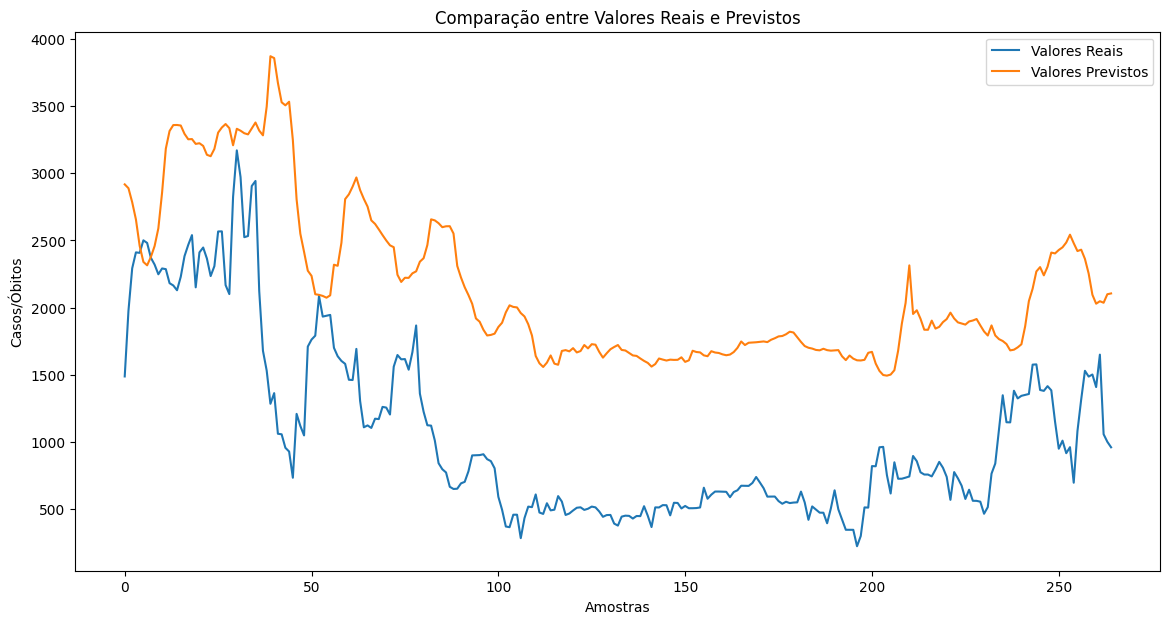

In [147]:

# Definição do modelo LSTM
# AUMENTAR PROGRESSIVAMENTE O NUMERO DE NEURONIOS
model = Sequential()
#1
model.add(LSTM(units=16, return_sequences=True, input_shape=(seq_length, 3)))
model.add(Dropout(0.3))

#2
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.3))

#3
model.add(LSTM(units=64,return_sequences=True))
model.add(Dropout(0.3))

#4
model.add(LSTM(units=128,return_sequences=True))
model.add(Dropout(0.3))

#5
model.add(LSTM(units=32,return_sequences=True))
model.add(Dropout(0.2))

#6
model.add(LSTM(units=64,return_sequences=True))
model.add(Dropout(0.2))

#7
model.add(LSTM(units=128,return_sequences=False))
model.add(Dropout(0.2))

#ANTES
#model = Sequential()
#model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 3)))
#model.add(Dropout(0.2))
#model.add(LSTM(units=50, return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(units=50))
#model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='rmsprop', loss='huber',metrics=['MAE'])
early_stopping = EarlyStopping(monitor='MAE', patience=25, restore_best_weights=True)


# Treinamento do modelo com EarlyStopping
history = model.fit(X_train, y_train, 
                    epochs=300, 
                    batch_size=300, 
                    validation_split=0.2
                   ,callbacks=[early_stopping]
                   )

y_pred = model.predict(X_test)
y_test_rescaled = sc_feature.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = sc_feature.inverse_transform(y_pred.reshape(-1, 1))
# Calculando as métricas de desempenho
#mae_casos = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mae_casos = mean_absolute_error(y_test_rescaled[:, 0], y_pred_rescaled[:, 0])
mse_casos = mean_squared_error(y_test_rescaled[:, 0], y_pred_rescaled[:, 0])
r2_casos = r2_score(y_test_rescaled[:, 0], y_pred_rescaled[:, 0])

report = f"""
Relatório de Assertividade:

Casos Novos:
- Mean Absolute Error (MAE): {mae_casos:.2f}
- Mean Squared Error (MSE): {mse_casos:.2f}
    - R-squared (R²): {r2_casos:.2f}
"""

print(report)

plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='Valores Reais')
plt.plot(y_pred_rescaled, label='Valores Previstos')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Amostras')
plt.ylabel('Casos/Óbitos')
plt.legend()
plt.show()

# Treinamento do modelo(2)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import backend as K


model_gru = Sequential()
model_gru.add(GRU(32, return_sequences=True, input_shape=(seq_length, 3)))
model_gru.add(Dropout(0.2))

model_gru.add(GRU(64, return_sequences=True))
model_gru.add(Dropout(0.2))


model_gru.add(GRU(128, return_sequences=True))
model_gru.add(Dropout(0.2))

model_gru.add(GRU(16, return_sequences=True))
model_gru.add(Dropout(0.2))

model_gru.add(GRU(32, return_sequences=True))
model_gru.add(Dropout(0.2))

model_gru.add(GRU(64, return_sequences=True))
model_gru.add(Dropout(0.2))

model_gru.add(GRU(128, return_sequences=False))
model_gru.add(Dropout(0.2))

model_gru.add(Dense(1))
model_gru.compile(optimizer='rmsprop', loss='huber',metrics=['MAE'])
early_stopping = EarlyStopping(monitor='MAE', patience=10, restore_best_weights=True)


model_gru.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test)
             ,callbacks=[early_stopping]
             )

print("----------------")
y_pred_gru = model_gru.predict(X_test)
y_test_rescaled = sc_feature.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = sc_feature.inverse_transform(y_pred_gru.reshape(-1, 1))
# Calculando as métricas de desempenho
#mae_casos = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mae_casos = mean_absolute_error(y_test_rescaled[:, 0], y_pred_rescaled[:, 0])
mse_casos = mean_squared_error(y_test_rescaled[:, 0], y_pred_rescaled[:, 0])
r2_casos = r2_score(y_test_rescaled[:, 0], y_pred_rescaled[:, 0])

report = f"""
Relatório de Assertividade:

Casos Novos:
- Mean Absolute Error (MAE): {mae_casos:.2f}
- Mean Squared Error (MSE): {mse_casos:.2f}
    - R-squared (R²): {r2_casos:.2f}
"""

print(report)

plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='Valores Reais')
plt.plot(y_pred_rescaled, label='Valores Previstos')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Amostras')
plt.ylabel('Casos/Óbitos')
plt.legend()
plt.show()


/home/c4p1t4n/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - MAE: 0.1923 - loss: 0.0318 - val_MAE: 0.0490 - val_loss: 0.0015
Epoch 2/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - MAE: 0.0849 - loss: 0.0069 - val_MAE: 0.0294 - val_loss: 6.1765e-04
Epoch 3/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - MAE: 0.0801 - loss: 0.0058 - val_MAE: 0.0245 - val_loss: 4.4871e-04
Epoch 4/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - MAE: 0.0754 - loss: 0.0054 - val_MAE: 0.0792 - val_loss: 0.0035
Epoch 5/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - MAE: 0.0881 - loss: 0.0073 - val_MAE: 0.0617 - val_loss: 0.0022
Epoch 6/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - MAE: 0.0775 - loss: 0.0057 - val_MAE: 0.0478 - val_loss: 0.0014
Epoch 7/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - MAE: 0.0808 - loss: 0.0059 - val_MAE: 0.0195 - val_loss: 3.5131e-04
Epoch 8/300
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - MAE: 0.0752 - loss: 0.0051 - val_MAE: 0.0255 - val_loss: 4.5289e-04
Epoch 9/300
34/34 ━━━━━━━━━━━━━━━━━━━━

In [93]:
X_test[0]

array([[0.57541523, 0.26340172],
       [0.6434508 , 0.29748511],
       [0.66579459, 0.3067505 ],
       [0.67657668, 0.30112508],
       [0.6885612 , 0.29814692],
       [0.68348727, 0.29947055],
       [0.64646345, 0.2822634 ]])

In [95]:
test_data[0]

array([0.10782259, 0.0129683 , 0.10620497, 0.10620497])

In [31]:
from joblib import dump

# Supondo que 'grid' seja seu objeto GridSearchCV já treinado

# Salvando o modelo com os melhores parâmetros
dump(model_gru, 'modelo_gru_latest.joblib')


['modelo_gru_latest.joblib']

In [32]:
from scikeras.wrappers import KerasClassifier

In [166]:
X_train.shape

AttributeError: 'ellipsis' object has no attribute 'shape'

In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
import kerastuner as kt
# Definindo a função para criar o modelo
def create_model(units1=32, units2=64, units3=128, units4=16, units5=32, units6=64, units7=128):
    model = Sequential()
    model.add(GRU(units1, return_sequences=True, input_shape=(seq_length, 3)))
    model.add(Dropout(0.2))
    
    model.add(GRU(units2, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(GRU(units3, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(GRU(units4, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(GRU(units5, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(GRU(units6, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(GRU(units7, return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(1))  # Ajuste conforme necessário para o seu problema
    model.compile(optimizer='rmsprop', loss='huber')  # Altere conforme necessário
    return model

# Parâmetros para o Grid Search
param_grid = {
    'units1': [32, 64],
    'units2': [64, 128],
    'units3': [128, 256],
    'units4': [16, 32],
    'units5': [32, 64],
    'units6': [64, 128],
    'units7': [128, 256],
}

# Criar o modelo usando KerasRegressor
model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=32, verbose=0)

# Configurar o Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Executar o Grid Search
grid_result = grid.fit(X_train, y_train)

# Resumo dos resultados
print("Melhor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))

# Exibindo os melhores parâmetros
print("Melhores parâmetros encontrados: ", grid_result.best_params_)
print("Melhor resultado (MAE): ", grid_result.best_score_)

# Resultados de todas as combinações de parâmetros
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print(f"MAE: {mean:.4f} (±{std:.4f}) para os parâmetros: {param}")


2024-10-01 00:54:54.317548: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-01 00:54:54.318338: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-01 00:54:54.322977: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-01 00:54:54.337345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 00:54:54.358696: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

KeyboardInterrupt: 

In [176]:
X_train.shape

(1078, 7, 3)

In [34]:
melhor_modelo

NameError: name 'melhor_modelo' is not defined

In [ ]:
from joblib import dump

# Supondo que 'grid' seja seu objeto GridSearchCV já treinado
melhor_modelo = grid.best_estimator_

print(melhor_modelo)
# Salvando o modelo com os melhores parâmetros
#dump(melhor_modelo, 'modelo_melhores_parametros_grid_search_01.joblib')


# Vizualização

In [ ]:
y_pred_gru = model_gru.predict(X_test)
y_test_rescaled = sc_feature.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = sc_feature.inverse_transform(y_pred_gru.reshape(-1, 1))
# Calculando as métricas de desempenho
#mae_casos = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mae_casos = mean_absolute_error(y_test_rescaled[:, 0], y_pred_rescaled[:, 0])
mse_casos = mean_squared_error(y_test_rescaled[:, 0], y_pred_rescaled[:, 0])
r2_casos = r2_score(y_test_rescaled[:, 0], y_pred_rescaled[:, 0])

report = f"""
Relatório de Assertividade:

Casos Novos:
- Mean Absolute Error (MAE): {mae_casos:.2f}
- Mean Squared Error (MSE): {mse_casos:.2f}
    - R-squared (R²): {r2_casos:.2f}
"""

print(report)

plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='Valores Reais')
plt.plot(y_pred_rescaled, label='Valores Previstos')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Amostras')
plt.ylabel('Novos casos mm7d')
plt.legend()
plt.show()

In [ ]:
X_test

In [ ]:
y_pred = model.predict(X_test)

#corrigir scaler
#predictions = scaler.inverse_transform(predictions)

In [ ]:
y_pred.shape

In [ ]:
y_pred.shape

In [ ]:
y_test.shape

In [ ]:
y_test_rescaled = sc_feature.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = sc_feature.inverse_transform(y_pred.reshape(-1, 1))

In [ ]:
y_test_rescaled

In [ ]:
# Calculando as métricas de desempenho
#mae_casos = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mae_casos = mean_absolute_error(y_test_rescaled[:, 0], y_pred_rescaled[:, 0])
mse_casos = mean_squared_error(y_test_rescaled[:, 0], y_pred_rescaled[:, 0])
r2_casos = r2_score(y_test_rescaled[:, 0], y_pred_rescaled[:, 0])

report = f"""
Relatório de Assertividade:

Casos Novos:
- Mean Absolute Error (MAE): {mae_casos:.2f}
- Mean Squared Error (MSE): {mse_casos:.2f}
    - R-squared (R²): {r2_casos:.2f}
"""

print(report)

plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='Valores Reais')
plt.plot(y_pred_rescaled, label='Valores Previstos')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Amostras')
plt.ylabel('Casos/Óbitos')
plt.legend()
plt.show()

# Teste com outro dataset

In [2]:
file_path = 'covid-cases.csv'
df = pd.read_csv(file_path, delimiter=',')

In [3]:
column_mapping = {
    'date': 'datahora',
    'country': 'pais',
    'state': 'estado',
    'population': 'pop',
    'confirmed': 'casos',
    'confirmed_1d': 'casos_novos',
    'confirmed_moving_avg_7d': 'casos_mm7d',
    'confirmed_moving_avg_7d_rate_14d': 'taxa_casos_mm7d_14d',
    'confirmed_trend': 'tendencia_casos',
    'deaths': 'obitos',
    'deaths_1d': 'obitos_novos',
        'deaths_moving_avg_7d': 'obitos_mm7d',
    'deaths_moving_avg_7d_rate_14d': 'taxa_obitos_mm7d_14d',
    'deaths_trend': 'tendencia_obitos',
    'month': 'mes',
    'year': 'ano'
}
df = df.rename(columns=column_mapping)

In [4]:
df['datahora'] = pd.to_datetime(df['datahora'])
df['casos_novos'] = pd.to_numeric(df['casos_novos'])
df['casos'] = pd.to_numeric(df['casos'])
df['obitos'] = pd.to_numeric(df['obitos'])
df['obitos_novos'] = pd.to_numeric(df['obitos_novos'])
df['casos_mm7d'] = pd.to_numeric(df['casos_mm7d'])
df['obitos_mm7d']  = pd.to_numeric(df['obitos_mm7d'])


In [5]:
df_train = df[['casos_novos','casos','obitos','obitos_novos','casos_mm7d','obitos_mm7d','datahora']]
df_train = df.groupby('datahora').agg({
    'casos_novos': 'sum',
    #'casos': 'sum',
    #'obitos': 'sum',
    'obitos_novos': 'sum',
    'casos_mm7d': 'mean',
    'obitos_mm7d': 'mean'
})
df_train['casos_novos'].fillna(method='ffill', inplace=True)  # Propaga o último valor para frente
from scipy.stats import mstats
df_train['casos_novos'] = mstats.winsorize(df_train['casos_novos'], limits=[0.05, 0.05])
  # Média móvel de 7 dias
df_train['casos_novos_corrigidos'] = df_train['casos_novos'].rolling(window=7, center=True).mean()
# Limita os 5% superiores e inferiores


/tmp/ipykernel_126749/3635843060.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['casos_novos'].fillna(method='ffill', inplace=True)  # Propaga o último valor para frente
/tmp/ipykernel_126749/3635843060.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train['casos_novos'].fillna(method='ffill', inplace=True)  # Propaga o último valor para frente


In [113]:
df_train = df_train.dropna(subset=['casos_novos_corrigidos','casos_mm7d','obitos_mm7d'])

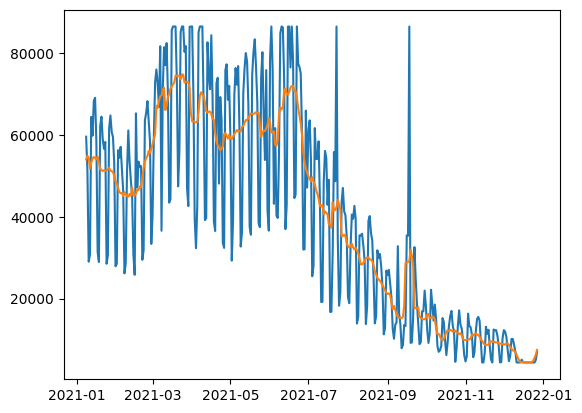

In [114]:
plt.plot(df_train['casos_novos'], label='Valores Reais')
plt.plot(df_train['casos_novos_corrigidos'], label='Valores Reais')

In [6]:
df_train

,casos_novos,obitos_novos,casos_mm7d,obitos_mm7d,casos_novos_corrigidos
datahora,,,,,
2021-01-01,4379.0,0.0,NaN,NaN,NaN
2021-01-02,15353.0,293.0,NaN,NaN,NaN
2021-01-03,17190.0,311.0,NaN,NaN,NaN
2021-01-04,25039.0,597.0,NaN,NaN,38439.857143
2021-01-05,58083.0,1188.0,NaN,NaN,46326.571429
...,...,...,...,...,...
2021-12-26,4969.0,46.0,136.370370,3.888889,6267.285714
2021-12-27,6952.0,65.0,159.222222,3.777778,7444.285714
2021-12-28,9052.0,181.0,187.370370,4.370370,NaN


In [7]:
df_train_copy = df_train
df_train = df_train[['obitos_novos','casos_mm7d','obitos_mm7d']]


In [8]:
df_train[0:7]

,obitos_novos,casos_mm7d,obitos_mm7d
datahora,,,
2021-01-01,0.0,NaN,NaN
2021-01-02,293.0,NaN,NaN
2021-01-03,311.0,NaN,NaN
2021-01-04,597.0,NaN,NaN
2021-01-05,1188.0,NaN,NaN
2021-01-06,1231.0,NaN,NaN
2021-01-07,1518.0,NaN,NaN


In [9]:
np.array(df_train[['obitos_novos','casos_mm7d','obitos_mm7d']][7:14])

array([[1081.        , 1723.77777778,   33.25925926],
       [1009.        , 1914.48148148,   37.07407407],
       [ 490.        , 1977.11111111,   38.11111111],
       [ 491.        , 2007.33333333,   37.48148148],
       [1125.        , 2040.92592593,   37.14814815],
       [1264.        , 2026.7037037 ,   37.2962963 ],
       [1154.        , 1922.92592593,   35.37037037]])

In [10]:
df_train_copy[['casos_novos_corrigidos']][7:14]

,casos_novos_corrigidos
datahora,
2021-01-08,53981.571429
2021-01-09,54887.428571
2021-01-10,54504.571429
2021-01-11,51904.714286
2021-01-12,53263.428571
2021-01-13,54270.857143
2021-01-14,54612.142857


In [11]:
n_scaler = MinMaxScaler()
n_sc_feature =  MinMaxScaler()
#df_train['obitos_novos'] = scaler.fit_transform(df_train[['obitos_novos']])
#df_train['casos_mm7d'] = scaler.fit_transform(df_train[['casos_mm7d']])
#df_train['obitos_mm7d']= scaler.fit_transform(df_train[['obitos_mm7d']])
#df_train['casos_novos'] =  sc_feature.fit_transform(df_train[['casos_novos']])
df_train = n_scaler.fit_transform(df_train)
feature_scaled = n_sc_feature.fit_transform(df_train_copy[['casos_novos_corrigidos']])

In [18]:
def create_sequences(data, seq_length):
    X, y = [], []
    print("Iniciando a criação das sequências")
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, 1:])  # Pegando todas as colunas exceto 'casos_novos'
        y.append(data[i + seq_length, 0])  # Pegando a coluna 'casos_novos'
    return np.array(X), np.array(y)
def create_test_sequences(data, seq_length):
    X_test, y_test = [], []
    print("Iniciando a criação das sequências de teste")
    for i in range(len(data) - seq_length):
        X_test.append(data[i:i + seq_length, 1:])  # Pegando todas as colunas exceto 'casos_novos'
        y_test.append(data[i + 1:i + seq_length + 1, 0])  # Criando sequência para 'casos_novos'
    return np.array(X_test), np.array(y_test).reshape(-1, seq_length, 1)

In [14]:
df_train

array([[0.        ,        nan,        nan],
       [0.07063645,        nan,        nan],
       [0.07497589,        nan,        nan],
       ...,
       [0.04363549, 0.02728558, 0.00529451],
       [0.02820636, 0.03962685, 0.00529451],
       [0.03712633, 0.05630211, 0.00595632]])

In [15]:
stack

NameError: name 'stack' is not defined

In [19]:
X_test, y_test = create_sequences(df_train, seq_length)

Iniciando a criação das sequências


In [20]:
y_test


array([0.26060752, 0.24324976, 0.11812922, 0.1183703 , 0.27121504,
       0.30472517, 0.27820636, 0.27362584, 0.24445516, 0.1328351 ,
       0.1147541 , 0.27965284, 0.33630665, 0.32473481, 0.25819672,
       0.27603664, 0.14344262, 0.16634523, 0.27844744, 0.32208293,
       0.3466731 , 0.262054  , 0.28736741, 0.13693346, 0.15019286,
       0.30400193, 0.28905497, 0.30761813, 0.30159113, 0.225892  ,
       0.11788814, 0.17381871, 0.31702025, 0.32810993, 0.34763742,
       0.29411765, 0.24710704, 0.15742527, 0.1472999 , 0.2632594 ,
       0.28664417, 0.34691418, 0.32087753, 0.24855352, 0.1460945 ,
       0.17140791, 0.32762777, 0.34860174, 0.37970106, 0.32377049,
       0.30183221, 0.18635487, 0.19961427, 0.41489875, 0.44551591,
       0.43587271, 0.41321119, 0.35920926, 0.26470588, 0.2704918 ,
       0.47034716, 0.57401157, 0.52917068, 0.51157184, 0.47155256,
       0.25795564, 0.32160077, 0.68707811, 0.64151398, 0.65670203,
       0.64030858, 0.57087753, 0.30062681, 0.3864513 , 0.75867

In [23]:
df_train

array([[0.        ,        nan,        nan],
       [0.07063645,        nan,        nan],
       [0.07497589,        nan,        nan],
       ...,
       [0.04363549, 0.02728558, 0.00529451],
       [0.02820636, 0.03962685, 0.00529451],
       [0.03712633, 0.05630211, 0.00595632]])

In [89]:
def create_sequences(data_x,data_y, seq_length):
    X, y = [], []
    print("Iniciando a criação das sequências")
    for i in range(len(data_x) - seq_length):
        X.append(data_x[i:i + seq_length])  # Pegando todas as colunas exceto 'casos_novos'
        y.append(data_y[i + seq_length, 0])  # Pegando a coluna 'casos_novos'
    return np.array(X), np.array(y)
seq_length = 7
test_x,test_y =  create_sequences(df_train,feature_scaled,seq_length)

Iniciando a criação das sequências


In [24]:
test_x[0]

NameError: name 'test_x' is not defined

In [25]:
y_pred_gru = model.predict(X_test)
y_test_rescaled = sc_feature.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = sc_feature.inverse_transform(y_pred_gru.reshape(-1, 1))
# Calculando as métricas de desempenho
#mae_casos = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mae_casos = mean_absolute_error(y_test_rescaled[:, 0], y_pred_rescaled[:, 0])
mse_casos = mean_squared_error(y_test_rescaled[:, 0], y_pred_rescaled[:, 0])
r2_casos = r2_score(y_test_rescaled[:, 0], y_pred_rescaled[:, 0])

report = f"""
Relatório de Assertividade:

Casos Novos:
- Mean Absolute Error (MAE): {mae_casos:.2f}
- Mean Squared Error (MSE): {mse_casos:.2f}
    - R-squared (R²): {r2_casos:.2f}
"""

print(report)

plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='Valores Reais')
plt.plot(y_pred_rescaled, label='Valores Previstos')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Amostras')
plt.ylabel('Casos/Óbitos')
plt.legend()
plt.show()

NameError: name 'model' is not defined